In [37]:
# Importing general libraries
from glob import iglob
import math
import time
import  sys
import difflib
import io
from contextlib import redirect_stdout
import os

# Import ML related libraries
import tensorflow as tf
import keras
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import backend as K
from keras.initializers import glorot_uniform
#from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix
#import lime
#import lime.lime_tabular
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# Checking the version of the of installed / available libraries
# print("Python: " + str(sys.version_info.major) + "." + str(sys.version_info.minor))
# print("Tensorflow: " + str(tf.__version__))
# print("Keras: " + str(keras.__version__))
# print("ScikitLearn: " + str(sklearn.__version__))
# print("Pandas: " + str(pd.__version__))
# print("NumPy: " + str(np.__version__))

# Fetching the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# MetaData
'''
Device_Listing = ['SimpleHome_XCS7_1003_WHT_Security_Camera',  
                 'SimpleHome_XCS7_1002_WHT_Security_Camera',
                 'Provision_PT_838_Security_Camera',
                 'Provision_PT_737E_Security_Camera',
                 'Danmini_Doorbell',
                 'Ennio_Doorbell',
                 'Ecobee_Thermostat',
                 'Samsung_SNH_1011_N_Webcam',
                 'Philips_B120N10_Baby_Monitor']
'''                 
#Device_Listing = ['Provision_PT_838_Security_Camera', 'Ecobee_Thermostat']


#Malware_Listing = ['Mirai','Bashlite']
#Malware_Listing = ['Bashlite']

Device_Listing = {
  #"192.168.10.1": ["Bot"],
  #"192.168.10.5": ["Bot"],
  #"192.168.10.8": ["Bot","Infiltration"],
  #"192.168.10.9": ["Bot"],
  #"192.168.10.12": ["Bot"],
  #"192.168.10.14": ["Bot"],
  #"192.168.10.15": ["Bot"],
  #"192.168.10.17": ["Bot"],
  "192.168.10.50": ["DDoS","DoS-GoldenEye","DoS-Hulk","DoS-Slowhttptest","FTP-Patator","Heartbleed","PortScan","SSH-Patator","Web-Attack-Brute-Force","Web-Attack-Sql-Injection","Web-Attack-XSS"],
  #"192.168.10.51": ["Heartblead"]
}
                   

# Setting Variables


In [39]:
# Environment Variables

# Known_Devices = ['SimpleHome_XCS7_1002_WHT_Security_Camera']
# Unknown_Devices = ['Philips_B120N10_Baby_Monitor']

# At the moment, it is not expected that both of the following booleans shall be true at the same time. Our analysis is for a single malware at a time.
# Run_For_Malware_Mirai = 1
# Run_For_Malware_Bashlite = 0

# Fisher Score Variables
fisher_score_use_top_n_features = 85 #(max value is 85, reducing this value will reduce the total pool of features to use in training)
use_features_with_fisher_score_greater_than = 0 #(when set to 0, will use all top_n features allowed in above variable. For none zero values, will only use features from the top_n variable above
                                                # whose fisher score is greater than the value set in this variable.)

# This name shall be used to generate relevant save file names at relevant paths
# savefilename='Known-SimpleHomeCamera_Unknown-Provision'
# transfer_savefilename='Transfer-Known-SimpleHomeCamera_Unknown-Provision'


#checkpoint_filepath=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/looped_run/original-checkpoint.h5"
#transfer_learning_checkpoint_filepath=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/looped_run/transfer-checkpoint.h5"

#results_file_path='/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/looped_run/looped_run_results.txt'
#F_Score_File='/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/looped_run/F_score_file.txt'


#### Functions

In [40]:
### Results file writing function

def createAndOpen(filepath, filename, mode):
  os.makedirs(filepath, exist_ok=True)
  return open(filename, mode)

def results_file_writing(data):
  resultsfile = createAndOpen(results_file_path, results_file_name, 'a+')
  resultsfile.write(data)
  resultsfile.close()

def buffer_results_file_writing():
  s = buffer.getvalue()
  resultsfile = createAndOpen(results_file_path, results_file_name, 'a+')
  resultsfile.write(s)
  resultsfile.close() 
  buffer.close()


def tl_results_file_writing(data):
  resultsfile = createAndOpen(tl_results_file_path, tl_results_file_name, 'a+')
  resultsfile.write(data)
  resultsfile.close()

def tl_buffer_results_file_writing():
  s = buffer.getvalue()
  resultsfile = createAndOpen(tl_results_file_path, tl_results_file_name, 'a+')
  resultsfile.write(s)
  resultsfile.close() 
  buffer.close()

### Write Buffer

buffer = io.StringIO()

In [41]:
def fisher_score(benigndf, attackdf, devicename, F_Score_File):

  rows_in_attack = attackdf.shape[0]
  rows_in_benign_test = benigndf.shape[0]

  if int(rows_in_benign_test) < int(rows_in_attack):
    benigndf = benigndf.iloc[:,:-1] # Creating Labeled datasets
    scaled_df_fisher = benigndf.append(attackdf.sample(n=benigndf.shape[0]))

  if int(rows_in_benign_test) > int(rows_in_attack):
    attackdf = attackdf.iloc[:,:-1]
    scaled_df_fisher = attackdf.append(benigndf.sample(n=attackdf.shape[0]))
  
  #print(scaled_df_fisher.shape)
  scored = [] # declare a list
  indices = {} # declare two dictionaries, purpose unknown
  shps = {}
  classes = ['benign','attack']

  for cl in classes:
      indices[cl] = scaled_df_fisher['class'] == cl # Now here, above created Fisher dataframe shall have two classes only.
                                           # so half of the time the comparison output shall be true and false
                                           # for the rest.
                                           # It creates a Pandas series
      shps[cl] = scaled_df_fisher[indices[cl]].shape[0] # dictionary contains the number of rows of benign traffic and the
                                               # number of rows for the attack traffic

  for col in scaled_df_fisher.columns: # Loop through all the columns of the Fisher DataFrame
      if col == 'class':  # if the column is that of "Class", then skip it.
          continue
      num = 0
      den = 0
      m = scaled_df_fisher[col].mean() # For the column under the current iteration, find the mean value.
                            # no, nothing strange about this. We are finding out the mean of each field/column
                            # in the dataset.
    
      for cl in classes: # For each column (this essentially means that we are considering that column at the moment)
                       # calculate the numerator and the denominator values for the Fisher score per class.
          num += (shps[cl] / scaled_df_fisher.shape[0]) * (m - scaled_df_fisher[indices[cl]][col].mean())**2
                # shps[cl] --> e.g if shps['benign'] then number of rows in it shall be 33032
                # (33032/66064) * ([mean-of-that-whole-column] - mean-of-rows-whose class was cl)**2
          den += (shps[cl] / scaled_df_fisher.shape[0]) * scaled_df_fisher[indices[cl]][col].var()
                # shps[cl] --> e.g if shps['benign'] then number of rows in it shall be 33032
                # (33032/66064) * (variance-of-rows-whose class was cl)
        
      score = {'feature': col, 'score': num / den}
      scored.append(score)
      #print(score)
  scored.sort(key=lambda x: x['score'], reverse=True)
  #scored[:115] #scored is a list of dictionaries    


  # Write down the calculated F-scores in a file.
  with open(F_Score_File, 'a+') as file:
      file.write('\n\n\n============================\n ' + str(devicename) + '\n============================')
      lines = ['\nFeature,Score\n']
      for s in scored:
          lines.append(str(s['feature']) + ',' + str("{0:.2f}".format(s['score'])) + '\n')
      file.writelines(lines)
      file.close()

  return scored

In [42]:
def anomaly_detect_func(device_benign_test, device_attack, known_device, mse_max, quantile_mse_max, model, scaler, confusion_matrix_figure):
  
  results_file_writing('\n\n=======\n Attempting Anomaly detection')

  rows_in_attack = device_attack.shape[0]
  rows_in_benign_test = device_benign_test.shape[0]

  if int(rows_in_benign_test) < int(rows_in_attack):
    anomaly_detect_01_df_benign = device_benign_test.iloc[:,:-1] # Creating Labeled datasets
    anomaly_detect_01_df_benign['malicious'] = 0
    anomaly_detect_01_df_malicious = device_attack.sample(n=device_benign_test.shape[0]).iloc[:,:-1] # Keeping equal parts of benign / malicious data
    anomaly_detect_01_df_malicious['malicious'] = 1

  if int(rows_in_benign_test) > int(rows_in_attack):
    anomaly_detect_01_df_malicious = device_attack.iloc[:,:-1]
    anomaly_detect_01_df_malicious['malicious'] = 1
    anomaly_detect_01_df_benign = device_benign_test.sample(n=device_attack.shape[0]).iloc[:,:-1]
    anomaly_detect_01_df_benign['malicious'] = 0

  anomaly_detect_01_df = anomaly_detect_01_df_benign.append(anomaly_detect_01_df_malicious)
  anomaly_detect_01_X_test = anomaly_detect_01_df.drop(columns=['malicious']).values
  anomaly_detect_01_Y_test = anomaly_detect_01_df['malicious'] # This shall form the ground truth series of values.
  #print(Y_test)

  #for threshold in [mse_max, quantile_mse.max()]:
  for threshold in [mse_max]:
    m = AnomalyModel(model , threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
    results_file_writing('\nTest-----------------\n')
    #print(f'suggensted threshodl n {best_n}')
    results_file_writing('\nAccuracy: ')
    anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_acc))

    results_file_writing('\nPrecision: ')
    anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_prec))

    results_file_writing('\nRecall: ')
    anomaly_detect_01_recall = recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_recall))

    results_file_writing('\nF1_Score: ')
    anomaly_detect_01_f1score = f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_f1score))

    results_file_writing('\nCM :')
    anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    results_file_writing(str(anomaly_detect_01_cm))  

    confusion_matrix_fig=confusion_matrix_figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(anomaly_detect_01_cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    labels=['0','1']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_fig)
    plt.show()

  
  return [anomaly_detect_01_acc, anomaly_detect_01_X_test, anomaly_detect_01_Y_test, anomaly_detect_01_prec, anomaly_detect_01_recall, anomaly_detect_01_f1score]

In [43]:
def best_results_finder(base_acc, mse, quantile_mse, model, scaler, known_device, anomaly_detect_01_X_test, anomaly_detect_01_Y_test, confusion_matrix_figure):

  results_file_writing('\n\n=======\n Attempting to Find the Best Threshold')
  
  #print('Starting Accuracy')
  starting_accuracy = base_acc
  #print(base_acc)

  new_percentile = 0.995
  some_increase_found = False

  best_acc = starting_accuracy
  best_percentile = 0.995

  for test_percentile in [0.995, 0.99, 0.985, 0.98, 0.975, 0.97, 0.965, 0.96, 0.955, 0.95, 0.945, 0.94, 0.935, 0.93, 0.925, 0.92, 0.915, 0.91, 0.905, 0.90]:
    print("Iterating through percentiles to find best threshold")
  
    threshold = mse[mse < mse.quantile(q=test_percentile)].max()
    results_file_writing(str('\nCurrent Percentile: ' + str(test_percentile)))
    results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
    new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str('\n new_acc: ' + str(new_acc) + ' ... new_precision: ' + str(new_precision)))

    if new_acc > best_acc:
      results_file_writing('\n new_acc > best_acc \n\n') 
      best_acc = new_acc
      best_percentile = test_percentile
    else:
      results_file_writing('\n NEW_ACC <= BEST_ACC \n\n')


  #if new_acc > starting_accuracy:
  if best_acc > starting_accuracy:

    results_file_writing('\n\n=======\n Found a Better Quantile, Results are: \n')

    #threshold = mse[mse < mse.quantile(q=previous_percentile)].max()
    threshold = mse[mse < mse.quantile(q=best_percentile)].max()
    #results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)

    results_file_writing('\n ------ Results ------\n')

    #results_file_writing(str('\nPercentile: ' + str(previous_percentile)))
    results_file_writing(str('\nPercentile: ' + str(best_percentile)))
    results_file_writing(str('\n Threshold: ' + str(threshold)))
    
    #print(f'suggensted threshodl n {best_n}')
    results_file_writing('\nAccuracy: ')
    anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_acc))

    results_file_writing('\nPrecision: ')
    anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_prec))

    results_file_writing('\nRecall: ')
    anomaly_detect_01_recall = recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_recall))

    results_file_writing('\nF1_Score: ')
    anomaly_detect_01_f1score = f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_f1score))

    results_file_writing('\nCM :')
    row_1, row_2 = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    tn = row_1[0]
    fp = row_1[1]
    fn = row_2[0]
    tp = row_2[1]
    anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    results_file_writing(str(anomaly_detect_01_cm))  

    confusion_matrix_fig=confusion_matrix_figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(anomaly_detect_01_cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    labels=['0','1']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_fig)
    plt.show()

    return [threshold, best_percentile, anomaly_detect_01_acc, anomaly_detect_01_prec, anomaly_detect_01_recall, anomaly_detect_01_f1score, tn, fp, fn, tp]

  else:
    results_file_writing('\n\n=======\n DID NOT find a Better Quantile, Results are: \n')

    threshold = mse[mse < mse.quantile(q=1)].max()
    #results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)

    results_file_writing('\n ------ Results ------\n')
    results_file_writing('\nPercentile: 1.0 (global setting)' )

    results_file_writing(str('\n Threshold: ' + str(threshold)))

    #print(f'suggensted threshodl n {best_n}')
    results_file_writing('\nAccuracy: ')
    anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_acc))

    results_file_writing('\nPrecision: ')
    anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_prec))

    results_file_writing('\nRecall: ')
    anomaly_detect_01_recall = recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_recall))

    results_file_writing('\nF1_Score: ')
    anomaly_detect_01_f1score = f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str(anomaly_detect_01_f1score))

    results_file_writing('\nCM :')
    row_1, row_2 = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    tn = row_1[0]
    fp = row_1[1]
    fn = row_2[0]
    tp = row_2[1]
    anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    results_file_writing(str(anomaly_detect_01_cm))  
 
    confusion_matrix_fig=confusion_matrix_figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(anomaly_detect_01_cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    labels=['0','1']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_fig)    
    plt.show()

    return [threshold, 1.0, anomaly_detect_01_acc, anomaly_detect_01_prec, anomaly_detect_01_recall, anomaly_detect_01_f1score, tn, fp, fn, tp]


'''
  while True:
    print("entering while loop")
    if new_percentile <= 0.9:
      results_file_writing('\nreached quite  low percentile of 0.90 ... Aborting\n')
      anomaly_detect_01_chosen_threshold = quantile_mse.max()
      results_file_writing('\nselected percentile for threshold is 1.0\n')
      results_file_writing(str('\nselected threshold is: ' + str(anomaly_detect_01_chosen_threshold)))    
      break
    threshold = mse[mse < mse.quantile(q=new_percentile)].max()
    results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
    new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    results_file_writing(str('\n new_acc: ' + str(new_acc) + ' ... new_precision: ' + str(new_precision)))
    if new_acc > base_acc:
      results_file_writing('\n new_acc > base_acc') 
      base_acc = new_acc
      previous_percentile = new_percentile
      new_percentile = new_percentile - 0.005
      results_file_writing(str('\n Next Percentile to test ' + str(new_percentile) + '\n-------------------\n'))
      some_increase_found = True
    elif new_acc < base_acc:
      results_file_writing('\n NEW-ACC < BASE-ACC')
      if some_increase_found:
        results_file_writing('\n New accuracy is lower than previous, stopping... ')
        results_file_writing(str('\n selected percentile for threshold is: ' + str(previous_percentile)))
        results_file_writing('\n selected threshold is: ')
        results_file_writing(str(threshold))
        anomaly_detect_01_chosen_threshold = threshold
        break
      previous_percentile = new_percentile
      new_percentile = new_percentile - 0.005
      results_file_writing(str('\n Next Percentile to test ' + str(new_percentile)))
      continue
    else:
      previous_percentile = new_percentile
      new_percentile = new_percentile - 0.005
      results_file_writing(str('\n Next Percentile to test: ' + str(new_percentile)))
'''



'\n  while True:\n    print("entering while loop")\n    if new_percentile <= 0.9:\n      results_file_writing(\'\nreached quite  low percentile of 0.90 ... Aborting\n\')\n      anomaly_detect_01_chosen_threshold = quantile_mse.max()\n      results_file_writing(\'\nselected percentile for threshold is 1.0\n\')\n      results_file_writing(str(\'\nselected threshold is: \' + str(anomaly_detect_01_chosen_threshold)))    \n      break\n    threshold = mse[mse < mse.quantile(q=new_percentile)].max()\n    results_file_writing(str(\'\nCurrent Threshold: \' + str(threshold)))\n    m = AnomalyModel(model, threshold, scaler)\n    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)\n    new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)\n    new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)\n    results_file_writing(str(\'\n new_acc: \' + str(new_acc) + \' ... new_precision: \' + str(new_precision)))\n    if new_acc > base_acc:

========================
========================

In [44]:
def unknown_anomaly_detect_func(device_benign_test, device_attack, known_device, mse_max, model, scaler, fs, confusion_matrix_figure):
  
  tl_results_file_writing('\n\n=======\n Attempting Anomaly detection - Function: Unknown Anomaly Detect')
  
  anomaly_detect_01_df_benign = device_benign_test[fs] # Creating Labeled datasets
  anomaly_detect_01_df_benign['malicious'] = 0

  # Removing randomness bias
  # df_malicious = df_known_device_attack.sample(n=df_known_device_benign_test.shape[0], random_state=406)[fs] # Keeping equal parts of benign / malicious data
  anomaly_detect_01_df_malicious = device_attack.sample(n=device_benign_test.shape[0])[fs] # Keeping equal parts of benign / malicious data
  anomaly_detect_01_df_malicious['malicious'] = 1

  anomaly_detect_01_df = anomaly_detect_01_df_benign.append(anomaly_detect_01_df_malicious)
  anomaly_detect_01_X_test = anomaly_detect_01_df.drop(columns=['malicious']).values
  anomaly_detect_01_Y_test = anomaly_detect_01_df['malicious'] # This shall form the ground truth series of values.
  #print(Y_test)

  #for threshold in [mse_max, quantile_mse.max()]:
  for threshold in [mse_max]:
    m = AnomalyModel(model , threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
    tl_results_file_writing('\nTest-----------------\n')
    #print(f'suggensted threshodl n {best_n}')
    tl_results_file_writing('\nAccuracy: ')
    anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_acc))

    tl_results_file_writing('\nPrecision: ')
    anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_prec))

    tl_results_file_writing('\nRecall: ')
    anomaly_detect_01_recall = recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_recall))

    tl_results_file_writing('\nF1_Score: ')
    anomaly_detect_01_f1score = f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_f1score))

    tl_results_file_writing('\nCM :')
    anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    tl_results_file_writing(str(anomaly_detect_01_cm))  

    confusion_matrix_fig=confusion_matrix_figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(anomaly_detect_01_cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    labels=['0','1']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_fig)
    plt.show()

  
  return [anomaly_detect_01_acc, anomaly_detect_01_X_test, anomaly_detect_01_Y_test, anomaly_detect_01_prec, anomaly_detect_01_recall, anomaly_detect_01_f1score]

In [45]:
def tl_best_results_finder(base_acc, mse, quantile_mse, model, scaler, malware, known_device, anomaly_detect_01_X_test, anomaly_detect_01_Y_test, confusion_matrix_figure):

  tl_results_file_writing('\n\n=======\n Attempting to Find the Best Threshold')
  
  #print('Starting Accuracy')
  starting_accuracy = base_acc
  #print(base_acc)

  new_percentile = 0.995
  some_increase_found = False

  best_acc = starting_accuracy
  best_percentile = 0.995

  for test_percentile in [0.995, 0.99, 0.985, 0.98, 0.975, 0.97, 0.965, 0.96, 0.955, 0.95, 0.945, 0.94, 0.935, 0.93, 0.925, 0.92, 0.915, 0.91, 0.905, 0.90]:
    print("Iterating through percentiles to find best threshold")
  
    threshold = mse[mse < mse.quantile(q=test_percentile)].max()
    tl_results_file_writing(str('\nCurrent Percentile: ' + str(test_percentile)))
    tl_results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
    new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str('\n new_acc: ' + str(new_acc) + ' ... new_precision: ' + str(new_precision)))

    if new_acc > best_acc:
      tl_results_file_writing('\n new_acc > best_acc \n\n') 
      best_acc = new_acc
      best_percentile = test_percentile
    else:
      tl_results_file_writing('\n NEW_ACC <= BEST_ACC \n\n')


  #if new_acc > starting_accuracy:
  if best_acc > starting_accuracy:

    tl_results_file_writing('\n\n=======\n Found a Better Quantile, Results are: \n')

    #threshold = mse[mse < mse.quantile(q=previous_percentile)].max()
    threshold = mse[mse < mse.quantile(q=best_percentile)].max()
    #results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)

    tl_results_file_writing('\n ------ Results ------\n')

    #tl_results_file_writing(str('\nPercentile: ' + str(previous_percentile)))
    tl_results_file_writing(str('\nPercentile: ' + str(best_percentile)))
    tl_results_file_writing(str('\n Threshold: ' + str(threshold)))
    
    #print(f'suggensted threshodl n {best_n}')
    tl_results_file_writing('\nAccuracy: ')
    anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_acc))

    tl_results_file_writing('\nPrecision: ')
    anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_prec))

    tl_results_file_writing('\nRecall: ')
    anomaly_detect_01_recall = recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_recall))

    tl_results_file_writing('\nF1_Score: ')
    anomaly_detect_01_f1score = f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_f1score))

    tl_results_file_writing('\nCM :')
    anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    tl_results_file_writing(str(anomaly_detect_01_cm))  

    confusion_matrix_fig=confusion_matrix_figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(anomaly_detect_01_cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    labels=['0','1']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_fig)
    plt.show()

    return [threshold, best_percentile, anomaly_detect_01_acc, anomaly_detect_01_prec, anomaly_detect_01_recall, anomaly_detect_01_f1score]

  else:
    tl_results_file_writing('\n\n=======\n DID NOT find a Better Quantile, Results are: \n')

    threshold = mse[mse < mse.quantile(q=1)].max()
    #results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)

    tl_results_file_writing('\n ------ Results ------\n')
    tl_results_file_writing('\nPercentile: 1.0 (global setting)' )

    tl_results_file_writing(str('\n Threshold: ' + str(threshold)))

    #print(f'suggensted threshodl n {best_n}')
    tl_results_file_writing('\nAccuracy: ')
    anomaly_detect_01_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_acc))

    tl_results_file_writing('\nPrecision: ')
    anomaly_detect_01_prec = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_prec))

    tl_results_file_writing('\nRecall: ')
    anomaly_detect_01_recall = recall_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_recall))

    tl_results_file_writing('\nF1_Score: ')
    anomaly_detect_01_f1score = f1_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str(anomaly_detect_01_f1score))

    tl_results_file_writing('\nCM :')
    anomaly_detect_01_cm = confusion_matrix(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred, labels=[0,1])
    tl_results_file_writing(str(anomaly_detect_01_cm))  
 
    confusion_matrix_fig=confusion_matrix_figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(anomaly_detect_01_cm)
    plt.title('Confusion matrix')
    fig.colorbar(cax)
    labels=['0','1']
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(confusion_matrix_fig)    
    plt.show()

    return [threshold, 1.0, anomaly_detect_01_acc, anomaly_detect_01_prec, anomaly_detect_01_recall, anomaly_detect_01_f1score]

'''
  while True:
    print("entering while loop")
    if new_percentile <= 0.9:
      tl_results_file_writing('\nreached quite  low percentile of 0.90 ... Aborting\n')
      anomaly_detect_01_chosen_threshold = quantile_mse.max()
      tl_results_file_writing('\nselected percentile for threshold is 1.0\n')
      tl_results_file_writing(str('\nselected threshold is: ' + str(anomaly_detect_01_chosen_threshold)))    
      break
    threshold = mse[mse < mse.quantile(q=new_percentile)].max()
    tl_results_file_writing(str('\nCurrent Threshold: ' + str(threshold)))
    m = AnomalyModel(model, threshold, scaler)
    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)
    new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)
    tl_results_file_writing(str('\n new_acc: ' + str(new_acc) + ' ... new_precision: ' + str(new_precision)))
    if new_acc > base_acc:
      tl_results_file_writing('\n new_acc > base_acc') 
      base_acc = new_acc
      previous_percentile = new_percentile
      new_percentile = new_percentile - 0.005
      tl_results_file_writing(str('\n Next Percentile to test ' + str(new_percentile) + '\n-------------------\n'))
      some_increase_found = True
    elif new_acc < base_acc:
      tl_results_file_writing('\n NEW-ACC < BASE-ACC')
      if some_increase_found:
        tl_results_file_writing('\n New accuracy is lower than previous, stopping... ')
        tl_results_file_writing(str('\n selected percentile for threshold is: ' + str(previous_percentile)))
        tl_results_file_writing('\n selected threshold is: ')
        tl_results_file_writing(str(threshold))
        anomaly_detect_01_chosen_threshold = threshold
        break
      previous_percentile = new_percentile
      new_percentile = new_percentile - 0.005
      tl_results_file_writing(str('\n Next Percentile to test ' + str(new_percentile)))
      continue
    else:
      previous_percentile = new_percentile
      new_percentile = new_percentile - 0.005
      tl_results_file_writing(str('\n Next Percentile to test: ' + str(new_percentile)))


'''


'\n  while True:\n    print("entering while loop")\n    if new_percentile <= 0.9:\n      tl_results_file_writing(\'\nreached quite  low percentile of 0.90 ... Aborting\n\')\n      anomaly_detect_01_chosen_threshold = quantile_mse.max()\n      tl_results_file_writing(\'\nselected percentile for threshold is 1.0\n\')\n      tl_results_file_writing(str(\'\nselected threshold is: \' + str(anomaly_detect_01_chosen_threshold)))    \n      break\n    threshold = mse[mse < mse.quantile(q=new_percentile)].max()\n    tl_results_file_writing(str(\'\nCurrent Threshold: \' + str(threshold)))\n    m = AnomalyModel(model, threshold, scaler)\n    anomaly_detect_01_Y_pred = m.predict(anomaly_detect_01_X_test)\n    new_acc = accuracy_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)\n    new_precision = precision_score(anomaly_detect_01_Y_test, anomaly_detect_01_Y_pred)\n    tl_results_file_writing(str(\'\n new_acc: \' + str(new_acc) + \' ... new_precision: \' + str(new_precision)))\n    if new_

#### AutoEncoder Model

In [46]:
# Now creating a ____________ model
def create_model(input_dim):
    inp = Input(shape=(input_dim,))
    encoder = Dense(int(math.ceil(0.80 * input_dim)), activation="tanh")(inp)
    encoder = Dense(int(math.ceil(0.60 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.40 * input_dim)), activation="tanh")(encoder)
    encoder = Dense(int(math.ceil(0.20 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.40 * input_dim)), activation="tanh")(encoder)
    decoder = Dense(int(math.ceil(0.60 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(int(math.ceil(0.80 * input_dim)), activation="tanh")(decoder)
    decoder = Dense(input_dim)(decoder)
    return Model(inp, decoder)

#### Anomaly Detection Class

In [47]:
 #A Class definition for executing predictions
class AnomalyModel:
    def __init__(self, model, threshold, scaler):
        self.model = model
        self.threshold = threshold
        self.scaler = scaler

    def predict(self, x):
        x_pred = self.model.predict(x)
        mse = np.mean(np.power(x - x_pred, 2), axis=1)
        y_pred = mse > self.threshold
        return y_pred.astype(int)

## Making a Giant Loop

192.168.10.50
fs: 77
Epoch 1/100
202/213 [===========================>..] - ETA: 0s - loss: 0.0123
Epoch 1: val_loss improved from inf to 0.04471, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-GoldenEye/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 6ms/step - loss: 0.0118 - val_loss: 0.0447
Epoch 2/100
203/213 [===========================>..] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.04471 to 0.04368, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-GoldenEye/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0437
Epoch 3/100
198/213 [==========================>...] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss improved from 0.04368 to 0.04348, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS201

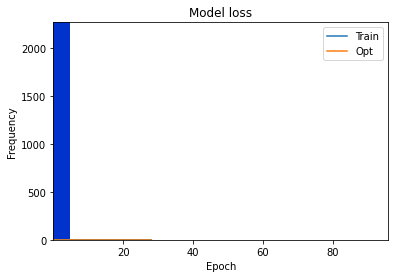

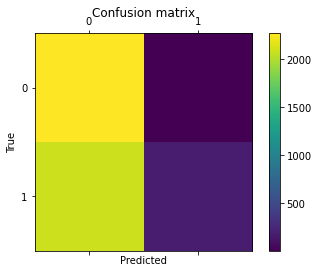

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

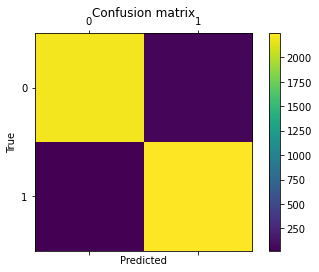

192.168.10.50
fs: 77
Epoch 1/100
204/213 [===========================>..] - ETA: 0s - loss: 0.0109
Epoch 1: val_loss improved from inf to 0.00296, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-Slowhttptest/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 6ms/step - loss: 0.0105 - val_loss: 0.0030
Epoch 2/100
205/213 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 2: val_loss improved from 0.00296 to 0.00178, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-Slowhttptest/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/100
208/213 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 3: val_loss improved from 0.00178 to 0.00177, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CIC

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


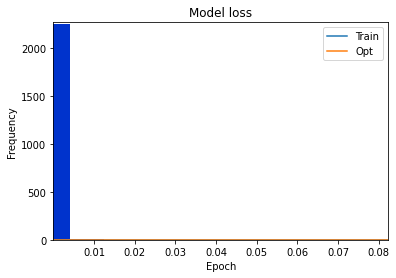

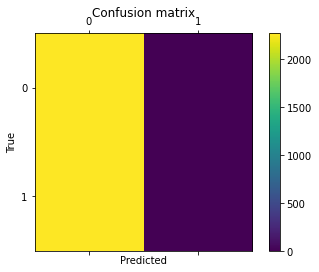

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

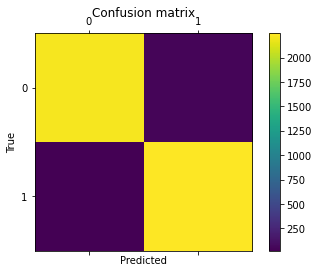

192.168.10.50
fs: 77
Epoch 1/100
213/213 [==============================] - ETA: 0s - loss: 0.0100
Epoch 1: val_loss improved from inf to 0.00289, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-Hulk/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 7ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 2/100
212/213 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00289 to 0.00256, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-Hulk/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 3/100
213/213 [==============================] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss improved from 0.00256 to 0.00131, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.

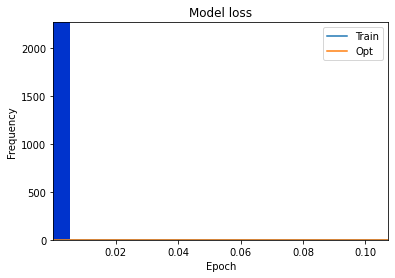

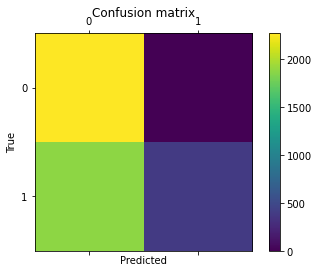

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

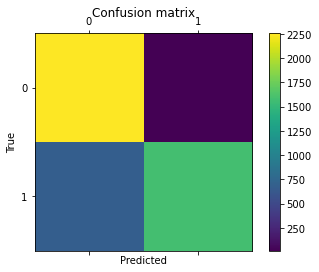

192.168.10.50
fs: 77
Epoch 1/100
212/213 [============================>.] - ETA: 0s - loss: 0.0113
Epoch 1: val_loss improved from inf to 0.00293, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-slowloris/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 6ms/step - loss: 0.0113 - val_loss: 0.0029
Epoch 2/100
203/213 [===========================>..] - ETA: 0s - loss: 0.0024
Epoch 2: val_loss improved from 0.00293 to 0.00189, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DoS-slowloris/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 3/100
204/213 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 3: val_loss improved from 0.00189 to 0.00150, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS201

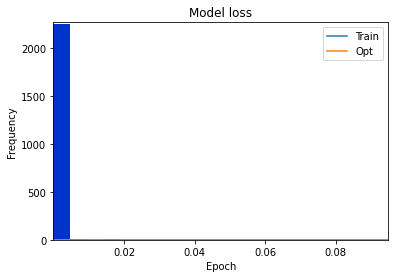

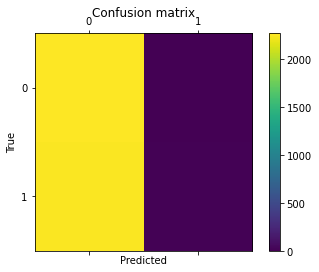

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

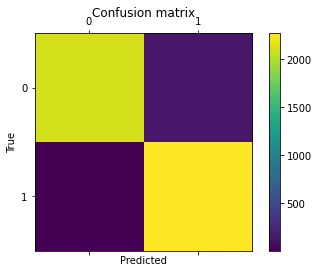

192.168.10.50
fs: 77
Epoch 1/100
203/213 [===========================>..] - ETA: 0s - loss: 0.0112
Epoch 1: val_loss improved from inf to 0.00287, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/PortScan/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 7ms/step - loss: 0.0108 - val_loss: 0.0029
Epoch 2/100
205/213 [===========================>..] - ETA: 0s - loss: 0.0022
Epoch 2: val_loss improved from 0.00287 to 0.00177, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/PortScan/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 3/100
210/213 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 3: val_loss improved from 0.00177 to 0.00155, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.

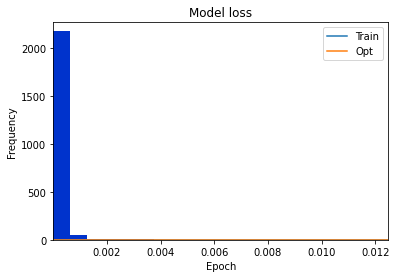

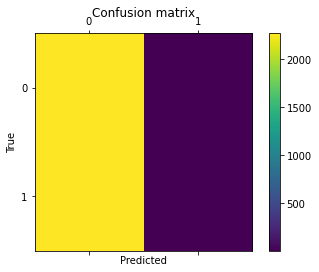

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

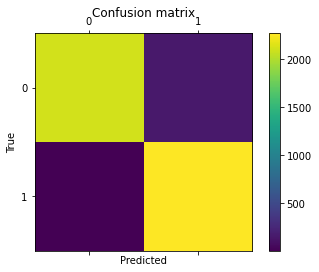

192.168.10.50
fs: 77
Epoch 1/100
201/213 [===========================>..] - ETA: 0s - loss: 0.0104
Epoch 1: val_loss improved from inf to 0.00265, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/FTP-Patator/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 6ms/step - loss: 0.0100 - val_loss: 0.0026
Epoch 2/100
213/213 [==============================] - ETA: 0s - loss: 0.0021
Epoch 2: val_loss improved from 0.00265 to 0.00225, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/FTP-Patator/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/100
207/213 [============================>.] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss improved from 0.00225 to 0.00172, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/19

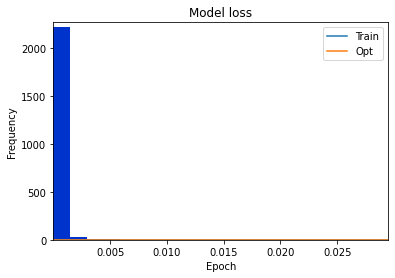

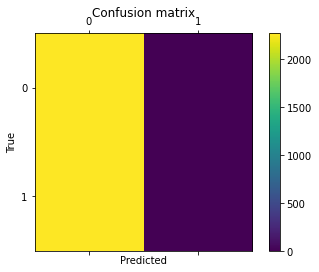

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

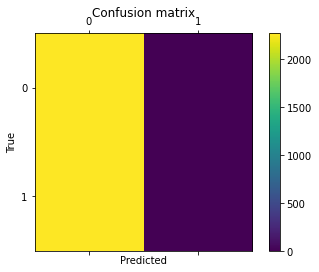

192.168.10.50
fs: 77
Epoch 1/100
211/213 [============================>.] - ETA: 0s - loss: 0.0115
Epoch 1: val_loss improved from inf to 0.00290, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DDoS/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 7ms/step - loss: 0.0115 - val_loss: 0.0029
Epoch 2/100
211/213 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00290 to 0.00206, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DDoS/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/100
200/213 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 3: val_loss improved from 0.00206 to 0.00149, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/DD

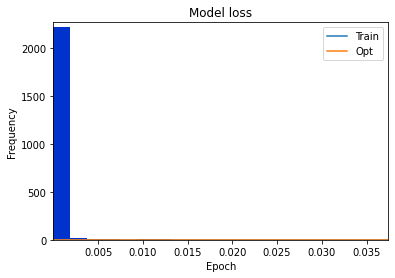

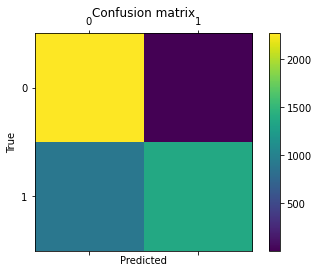

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

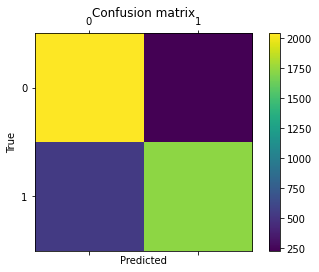

192.168.10.50
fs: 77
Epoch 1/100
208/213 [============================>.] - ETA: 0s - loss: 0.0127
Epoch 1: val_loss improved from inf to 0.00281, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/SSH-Patator/original-model/original-checkpoint.h5
213/213 [==============================] - 4s 7ms/step - loss: 0.0125 - val_loss: 0.0028
Epoch 2/100
207/213 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00281 to 0.00163, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/SSH-Patator/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 4ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 3/100
199/213 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 3: val_loss improved from 0.00163 to 0.00121, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/19

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


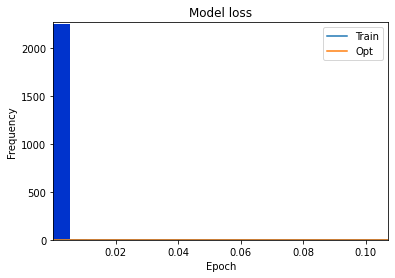

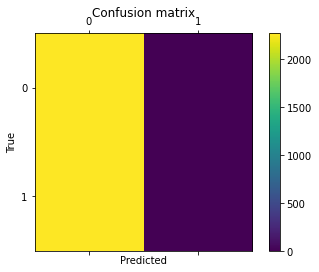

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

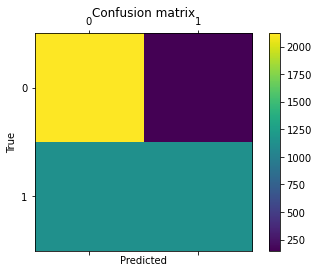

192.168.10.50
fs: 77
Epoch 1/100
208/213 [============================>.] - ETA: 0s - loss: 0.0104
Epoch 1: val_loss improved from inf to 0.08726, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/Web-Attack-Brute-Force/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 7ms/step - loss: 0.0102 - val_loss: 0.0873
Epoch 2/100
212/213 [============================>.] - ETA: 0s - loss: 0.0022
Epoch 2: val_loss improved from 0.08726 to 0.08602, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/Web-Attack-Brute-Force/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0860
Epoch 3/100
206/213 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 3: val_loss improved from 0.08602 to 0.08572, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transfer

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


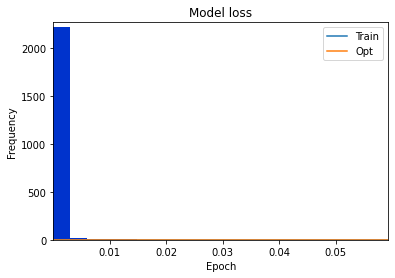

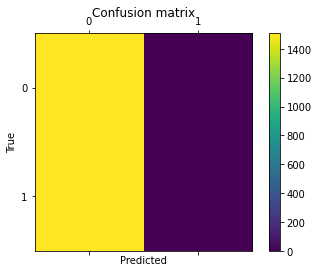

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

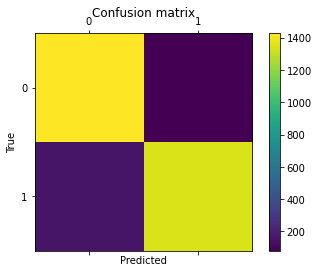

192.168.10.50
fs: 77
Epoch 1/100
207/213 [============================>.] - ETA: 0s - loss: 0.0110
Epoch 1: val_loss improved from inf to 0.00292, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/Web-Attack-Sql-Injection/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 7ms/step - loss: 0.0108 - val_loss: 0.0029
Epoch 2/100
212/213 [============================>.] - ETA: 0s - loss: 0.0023
Epoch 2: val_loss improved from 0.00292 to 0.00214, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/Web-Attack-Sql-Injection/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 3/100
199/213 [===========================>..] - ETA: 0s - loss: 0.0017
Epoch 3: val_loss improved from 0.00214 to 0.00141, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-tran

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


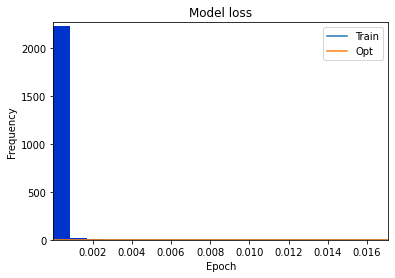

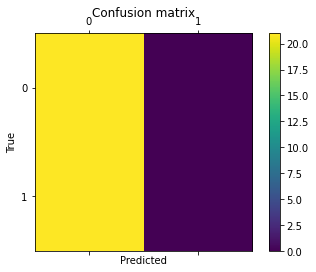

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

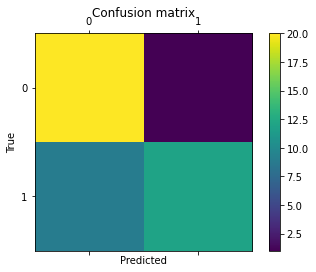

192.168.10.50
fs: 77
Epoch 1/100
205/213 [===========================>..] - ETA: 0s - loss: 0.0109
Epoch 1: val_loss improved from inf to 0.00277, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/Web-Attack-XSS/original-model/original-checkpoint.h5
213/213 [==============================] - 3s 7ms/step - loss: 0.0107 - val_loss: 0.0028
Epoch 2/100
209/213 [============================>.] - ETA: 0s - loss: 0.0025
Epoch 2: val_loss improved from 0.00277 to 0.00211, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/192.168.10.50/Web-Attack-XSS/original-model/original-checkpoint.h5
213/213 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 3/100
207/213 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 3: val_loss improved from 0.00211 to 0.00156, saving model to /content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2

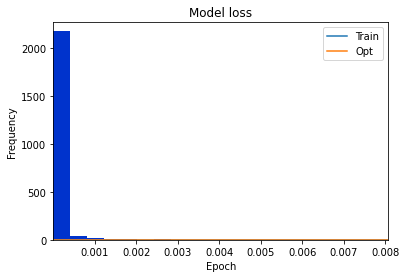

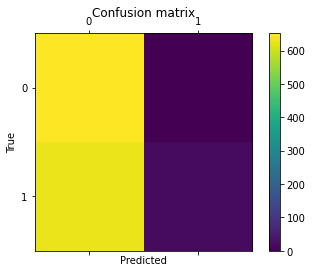

Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best threshold
Iterating through percentiles to find best thr

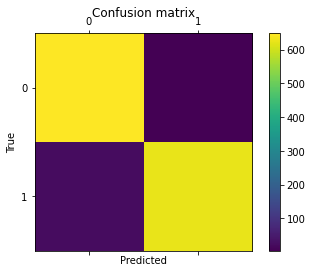

In [48]:
for known_device in Device_Listing:

  datapath = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{known_device}/attack/"

  directory_listing = os.listdir(datapath)
  attack_categories = []
  for item in directory_listing:
    path = f"{datapath}{item}"
    if os.path.isdir(path):
      attack_categories.append(item)

  for category in attack_categories:
    ### Defining file location variables

    checkpoint_filepath=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/original-checkpoint.h5"
    results_file_path=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}"
    results_file_name=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/looped_run_results.txt"
    Known_F_Score_File=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/F_score_file.txt"
    
    known_device_confusion_matrix_figure_percentile_1=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/anomaly-detect-CM-percentile-1.png"
    known_device_confusion_matrix_figure_best_percentile=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/anomaly-detect-CM-percentile-best.png"
    
    #results_file_writing(str('\n\n\n ==== \n LOOPING FOR MALWARE: '  + str(malware) + '\n'))
    results_file_writing('KNOWN DEVICE: ' + str(known_device) + '\n')

    ### Gathering Benign data of the known device

    filepaths = []
    print(known_device)
    benign_path = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{known_device}/benign/monday-benign-data.csv"
    filepaths.append(benign_path)

    df_known_device_benign = pd.concat((pd.read_csv(f, header=None, index_col=0) for f in filepaths), ignore_index=True)

    df_known_device_benign = df_known_device_benign.loc[:,7:83]
    df_known_device_benign.astype(float)
    df_known_device_benign.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_known_device_benign.fillna(0, inplace=True)
    
    results_file_writing("\n Benign DataFrame Information\n------")
    
    buffer = io.StringIO()
    df_known_device_benign.info(buf=buffer)
    buffer_results_file_writing()
    results_file_writing('\n\n')

    ### Gathering Attack data of the known device

    results_file_writing("\n\n LOADING ATTACK DATA OF KNOWN DEVICE AGAINST MALWARE \n")
    
    attack_filepaths = []
    attack_path = f"/content/drive/My Drive/thesis-unsub/data-PerIPData/{known_device}/attack/{category}/attack.csv"
    attack_filepaths.append(attack_path)

    results_file_writing(str(attack_path))

    df_known_device_attack= pd.concat((pd.read_csv(f, header=None, index_col=0) for f in attack_filepaths), ignore_index=True)
    
    df_known_device_attack = df_known_device_attack.loc[:,7:83]
    df_known_device_attack.astype(float)
    df_known_device_attack.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_known_device_attack.fillna(0, inplace=True)

    results_file_writing("\n Attack DataFrame Information\n------")
    buffer = io.StringIO()
    df_known_device_attack.info(buf=buffer)
    buffer_results_file_writing()
    results_file_writing('\n\n')    


    ### Splitting the benign dataset of the Known dataset.

    results_file_writing("\n\n\n Splitting Benign Data into 3 parts for training, optimization and test in a 60/20/20 split\n")

    df_known_device_benign_train, df_known_device_benign_opt, df_known_device_benign_test = np.split(df_known_device_benign.sample(frac=1), [int(3/5*len(df_known_device_benign)), int(4/5*len(df_known_device_benign))])

    results_file_writing("Split Information\n")
    results_file_writing("df_known_device_benign_train: " + str(df_known_device_benign_train.shape) + "\n")
    results_file_writing("df_known_device_benign_opt:   " + str(df_known_device_benign_opt.shape) + "\n")
    results_file_writing("df_known_device_benign_test:  " + str(df_known_device_benign_test.shape) + "\n")


    results_file_writing("\n\n Information about the Split\nTraining Data\n---")
    buffer = io.StringIO()
    df_known_device_benign_train.info(buf=buffer)
    buffer_results_file_writing()

    results_file_writing("\n Optimization Data\n---")
    buffer = io.StringIO()
    df_known_device_benign_opt.info(buf=buffer)
    buffer_results_file_writing()

    results_file_writing("\n Test Data \n---")
    buffer = io.StringIO()
    df_known_device_benign_test.info(buf=buffer)
    buffer_results_file_writing() 

    ### Scaling the bengin and attack datasets of the known device.
    scaler = MinMaxScaler()
    scaled_df_known_device_benign_train = scaler.fit_transform(df_known_device_benign_train)
    scaled_df_known_device_benign_opt = scaler.transform(df_known_device_benign_opt)
    scaled_df_known_device_benign_test = scaler.transform(df_known_device_benign_test)
    scaled_df_known_device_attack = scaler.transform(df_known_device_attack)
    #Converting NumPy arrays back to Pandas DataFrames
    scaled_df_known_device_benign_train = pd.DataFrame(scaled_df_known_device_benign_train)
    scaled_df_known_device_benign_opt = pd.DataFrame(scaled_df_known_device_benign_opt)
    scaled_df_known_device_benign_test = pd.DataFrame(scaled_df_known_device_benign_test)
    scaled_df_known_device_attack = pd.DataFrame(scaled_df_known_device_attack)    


    ### Labelling the data.
    scaled_df_known_device_attack['class'] = 'attack'
    scaled_df_known_device_benign_train['class'] = 'benign'
    scaled_df_known_device_benign_opt['class'] = 'benign'
    scaled_df_known_device_benign_test['class'] = 'benign'    

    ### FisherScoring Function
    scores = fisher_score(scaled_df_known_device_benign_train, scaled_df_known_device_attack, known_device, Known_F_Score_File)

    results_file_writing('\n\n\n --> Calculated the Fisher Score for known Device, see the F_Score_file')

    ### Model Training Time
    results_file_writing('\n\n\n --> Starting AutoEncoder Model Training')

    DF_BENIGN_TRAIN = scaled_df_known_device_benign_train.iloc[:,:-1]
    DF_BENIGN_OPT = scaled_df_known_device_benign_opt.iloc[:,:-1]
    DF_BENIGN_TEST = scaled_df_known_device_benign_test.iloc[:,:-1]

    fs = DF_BENIGN_TRAIN.shape[1]
    print("fs: " + str(fs))

    model = create_model(fs)
    model.compile(loss="mean_squared_error",
                    optimizer="nadam")
    
    Initial_Weights = model.get_weights()

    cp = ModelCheckpoint(filepath=checkpoint_filepath,
                                  monitor='val_loss',
                               save_best_only=True,
                               verbose=1)
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    start = time.time()
    epochs = 100
    history = model.fit(DF_BENIGN_TRAIN, DF_BENIGN_TRAIN,
                    epochs=epochs,
                    validation_data=(DF_BENIGN_OPT, DF_BENIGN_OPT),
                    verbose=1,
                    callbacks=[cp, es])
    end = time.time()
    results_file_writing('\n\n ----> Model Training Time Is: ')
    results_file_writing(str(end - start))
    results_file_writing('\n\n')

    with open(results_file_name, 'at') as f:
      with redirect_stdout(f):
        model.summary()
    f.close()

    original_model_path=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/model.h5"
    model.save(original_model_path)

    original_model_plot_path=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/training-plot.png"
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Opt'], loc='upper left')
    plt.savefig(original_model_plot_path)    
    #plt.show()

    ### Defining Anomaly Error Threshold

    results_file_writing('\n\n  <<  Defining Anomaly Threshold  >>  \n\n')
    
    df_benign_known_device_test_predictions = model.predict(scaled_df_known_device_benign_test.iloc[:,:-1])
    difference = scaled_df_known_device_benign_test.iloc[:,:-1] - df_benign_known_device_test_predictions
    
    mse = np.mean(np.power(scaled_df_known_device_benign_test.iloc[:,:-1] - df_benign_known_device_test_predictions, 2), axis=1) # Mean-Squared-Error is calculated for each row,
    mean = mse.mean() # We calculate the mean of the whole series, that is the mean mse for all the benign test cases.
    std = mse.std() # And we calculate the standard deviation of the mse series, containing only the test cases.

    mse = pd.Series(mse) #converting np array to dataframe series

    results_file_writing(str("MIN of MSE: " + str(mse.min())) + "\n")
    results_file_writing(str("MAX of MSE: " + str(mse.max())) + "\n")
    results_file_writing(str("MEAN of MSE: " + str(mean)) + "\n")
    results_file_writing(str("STD of MSE:  " + str(std)) + "\n")

    mse_min = mse.min()
    mse_max = mse.max()
    results_file_writing(str("\nMax Threshold = MSE_MAX: " + str(mse_max))  + "\n")

    max_std_multiplier = int((mse_max - mean) / std)
    results_file_writing(str("\nMAX_STD_Multiplier = " + str(max_std_multiplier)) + "\n")

    original_model_error_distribution=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/error-distribution.png"
    mse_plot = mse.plot.hist(bins=20, color='#0033cc')
    mse_plot.set_facecolor('#ffffff')
    mse_plot.set_xlim((mse_min, mse_max))
    mse_plot.set_ylim((0, mse[mse <= mse_max].count()))
    fig = mse_plot.get_figure()
    fig.savefig(original_model_error_distribution)

    
    ### Doing the quantile MSE stuff
    results_file_writing('\n\n --> Doing the quantile MSE stuff\n')

    test_percentile = 1
    quantile_mse = mse[mse <= mse.quantile(q=test_percentile)]  # <= is important here

    results_file_writing(str("MIN of QUANTILE_MSE: " + str(quantile_mse.min())))
    results_file_writing(str("MAX of QUANTILE_MSE: " + str(quantile_mse.max())))
    results_file_writing(str("MEAN of QUANTILE_MSE: " + str(quantile_mse.mean())))
    results_file_writing(str("STD of QUNATILE_MSE:  " + str(quantile_mse.std())))
    results_file_writing(str("Size of Series below 95th quantile: " + str(quantile_mse.size)))
    results_file_writing(str("\nSuggested Minimum Threshold = QUANTILE_MSE_MAX: " + str(quantile_mse.max())))

    min_std_multiplier = int((quantile_mse.max() - quantile_mse.mean()) / quantile_mse.std())
    results_file_writing(str("\nMIN_STD_Multiplier = " + str(min_std_multiplier)))

    original_model_quantile_error_distribution=f"/content/drive/My Drive/thesis-unsub/unsub/anomaly-transferlearning/CICIDS2017/{known_device}/{category}/original-model/quantile-error-distribution.png"
    quantile_mse_plot = quantile_mse.plot.hist(bins=20, color='#0033cc')
    quantile_mse_plot.set_facecolor('#ffffff')
    quantile_mse_plot.set_xlim((quantile_mse.min(), quantile_mse.max()))
    quantile_mse_plot.set_ylim((0, quantile_mse[quantile_mse <= quantile_mse.max()].count()))
    fig = mse_plot.get_figure()
    fig.savefig(original_model_quantile_error_distribution)


    ### Getting a base accuracy of the model using MSE-MAX threshold.

    results = anomaly_detect_func(scaled_df_known_device_benign_test, scaled_df_known_device_attack, known_device, mse_max, quantile_mse.max(), model, scaler, known_device_confusion_matrix_figure_percentile_1)
    base_acc = results[0]    
    anomaly_detect_01_X_test = results[1]
    anomaly_detect_01_Y_test  = results[2]



    ### Finding the threshold with best scores

    results_file_writing('\n\n <<--=== Finding Best Performning Threshold ===-->> \n')

    original_model_best_results = best_results_finder(base_acc, mse, quantile_mse, model, scaler, known_device, anomaly_detect_01_X_test, anomaly_detect_01_Y_test, known_device_confusion_matrix_figure_best_percentile)
    original_model_best_threshold = original_model_best_results[0]
    original_model_best_percentile = original_model_best_results[1]
    original_model_best_accuracy = original_model_best_results[2]
    original_model_best_precision = original_model_best_results[3]
    original_model_best_recall = original_model_best_results[4]
    original_model_best_f1score = original_model_best_results[5]
    original_model_best_tn = original_model_best_results[6]
    original_model_best_fp = original_model_best_results[7]
    original_model_best_fn = original_model_best_results[8]
    original_model_best_tp = original_model_best_results[9]


    ### 
    results_file_writing('\n\n\n ===-->>> KNOWN DEVICE - ORIGINAL MODEL PERFORMANCE ')
    results_file_writing(str(known_device))
    results_file_writing('\n')
    results_file_writing(str('ACCURACY: ' + str(original_model_best_accuracy)))
    results_file_writing('\n')
    results_file_writing(str('PRECISION: ' + str(original_model_best_precision)))
    results_file_writing('\n')
    results_file_writing(str('RECALL: ' + str(original_model_best_recall)))
    results_file_writing('\n')
    results_file_writing(str('F1-SCORE: ' + str(original_model_best_f1score)))
    results_file_writing('\n')
    results_file_writing(str('TP: ' + str(original_model_best_tp)))
    results_file_writing('\n')
    results_file_writing(str('TN: ' + str(original_model_best_tn)))
    results_file_writing('\n')
    results_file_writing(str('FP: ' + str(original_model_best_fp)))
    results_file_writing('\n')
    results_file_writing(str('FN: ' + str(original_model_best_fn)))             
    results_file_writing('\n ------- \n')
